In [1]:
# Load libraries
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [2]:
path = "/home/nachshon/Documents/Genetics/IRIScopy.csv"
#names = ['group','Any_PTSD_LT','PPGENDER','SUM_NUMBER_OF_LIFETIME_TRAUMAS','child_abuse',
#         'trauma_dichotomous','SOCIAL_SUPPORT_SUM','MDD','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
#         'rs1049353','rs12720071','rs806368','rs324420']
dataset = pd.read_csv(path)

In [3]:
# shape
print(dataset.shape)

(1895, 22)


In [4]:
print(dataset.head(5))

  group  Any_PTSD_LT  PPGENDER  SUM_NUMBER_OF_LIFETIME_TRAUMAS  child_abuse  \
0     G            0         1                               1            0   
1     G            0         1                               6            0   
2     G            0         1                               3            0   
3     G            0         2                               3            0   
4     G            0         1                               2            0   

   trauma_dichotomous  SOCIAL_SUPPORT_SUM  MDD     PC1     PC2  ...     PC5  \
0                   0                  20    0 -0.0081 -0.0036  ...  0.0053   
1                   1                  14    1 -0.0065 -0.0025  ...  0.0043   
2                   0                  22    1 -0.0076 -0.0033  ... -0.0014   
3                   0                  15    0 -0.0084 -0.0037  ...  0.0017   
4                   0                  16    0 -0.0085 -0.0029  ...  0.0012   

      PC6     PC7     PC8     PC9    PC10  rs10493

In [5]:
# descriptions
print(dataset.describe())

       Any_PTSD_LT     PPGENDER  SUM_NUMBER_OF_LIFETIME_TRAUMAS  child_abuse  \
count  1895.000000  1895.000000                     1895.000000  1895.000000   
mean      0.070712     1.093931                        3.701847     0.024802   
std       0.256411     0.291810                        2.431592     0.155563   
min       0.000000     1.000000                        1.000000     0.000000   
25%       0.000000     1.000000                        2.000000     0.000000   
50%       0.000000     1.000000                        3.000000     0.000000   
75%       0.000000     1.000000                        5.000000     0.000000   
max       1.000000     2.000000                       14.000000     1.000000   

       trauma_dichotomous  SOCIAL_SUPPORT_SUM          MDD          PC1  \
count         1895.000000         1895.000000  1895.000000  1895.000000   
mean             0.437467           19.443799     0.160422    -0.007694   
std              0.496205            4.950961     0.36

In [6]:
# class distribution
print(dataset.groupby(['group','Any_PTSD_LT']).size())

group  Any_PTSD_LT
G      0               471
       1                38
V      0              1290
       1                96
dtype: int64


In [7]:
# seperate gentic factors vs behvioural factors
beh = dataset.iloc[:,1:8]
gen = dataset.iloc[:,18:]
subset = pd.concat([beh, gen],axis=1, sort=False) 

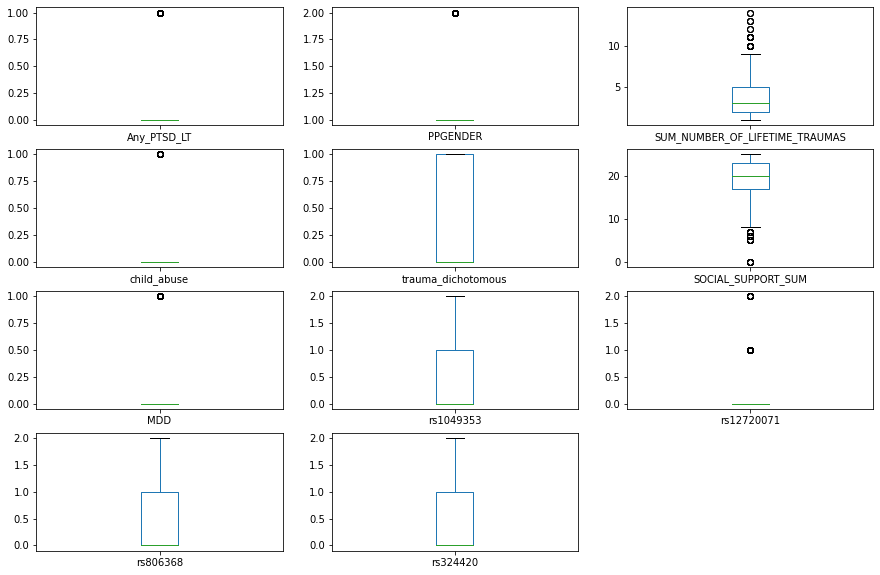

In [8]:
# box and whisker plots
subset.plot(kind='box', subplots=True, layout = (4,3), figsize=(15,10), sharex=False, sharey=False)
pyplot.show()

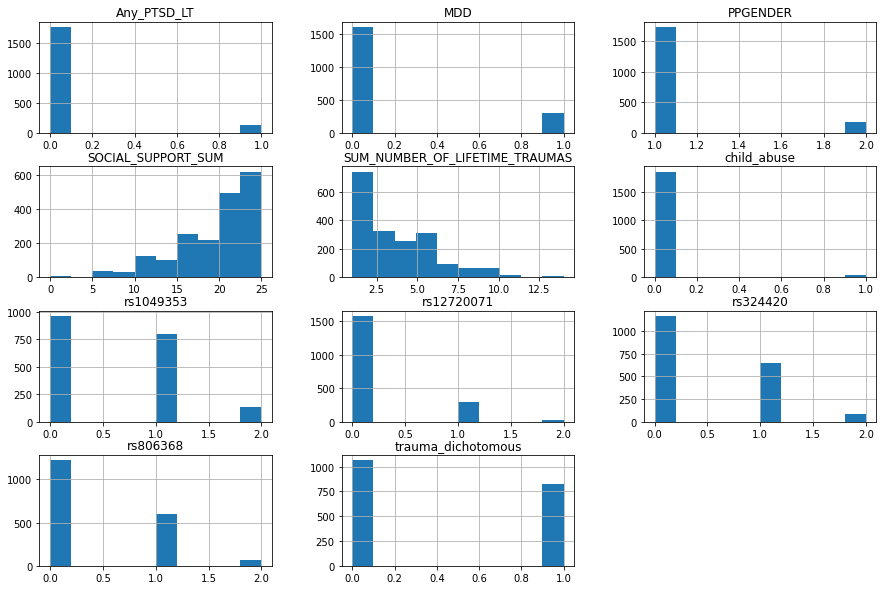

In [9]:
# histograms
subset.hist(figsize=(15,10))
pyplot.show()

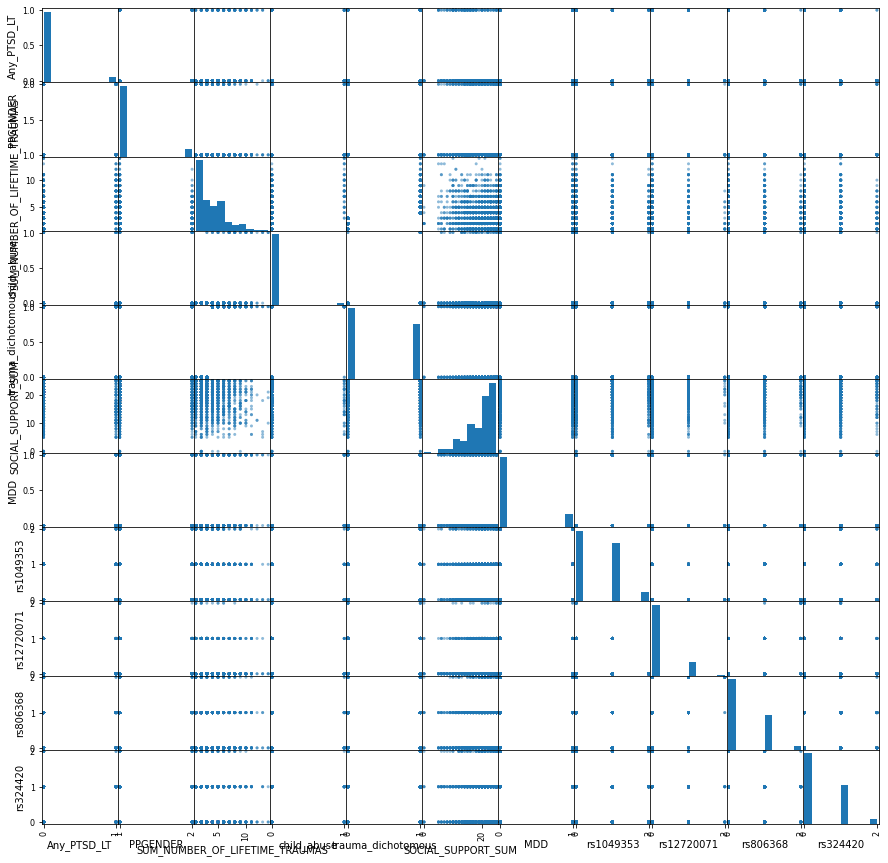

In [10]:
#scatter plot matrix
scatter_matrix(subset, figsize=(15,15))
pyplot.show()

In [54]:
# subset the two cohort. The big cohort ('V') will be used to build and test the algoritm and tone hyper
# parameters. Final test will be on the second cohort ('G')

evaluate = dataset[dataset['group']=='V']
pred = dataset[dataset['group']=='G']

pred_X = pred.iloc[:,2:]
pred_y = pred.iloc[:,1]
# In order to test the contribuation of the behavioural factors and genetics, they were divided into 2 seperate
# databases.

beh = evaluate.iloc[:,1:8]
gen = pd.concat([evaluate.iloc[:,1], evaluate.iloc[:,8:]],axis=1, sort=False) 

X = evaluate.iloc[:,2:]
y = evaluate.iloc[:,1]

Xb = beh.iloc[:,1:]
yb = beh.iloc[:,0]

Xg = gen.iloc[:,1:]
yg = gen.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, random_state=1)
Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg, yg, test_size=0.3, random_state=1)

In [12]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('wLR', LogisticRegression(solver='liblinear', multi_class='ovr',class_weight={1: 10})))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('wSVM', SVC(gamma='auto', class_weight={1: 10})))
models.append(('GB', GradientBoostingClassifier(n_estimators=1000)))
models.append(('ADB', AdaBoostClassifier(n_estimators=1000)))

In [15]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.436177 (0.180844)
LDA: 0.493941 (0.207325)
wLR: 0.430266 (0.099389)
KNN: 0.241597 (0.162956)
CART: 0.211771 (0.157475)
NB: 0.438615 (0.136107)
SVM: 0.128030 (0.133777)
wSVM: 0.356146 (0.079261)
GB: 0.235180 (0.149835)
ADB: 0.320403 (0.121142)


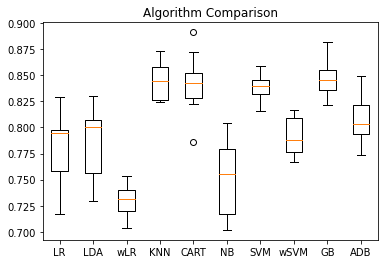

In [50]:
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [61]:
#over sample PTSD
from imblearn.over_sampling import SMOTE
import numpy as np


sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [20]:
# evaluate each model in turn with over sampling
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, x_train_res, y_train_res, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.832814 (0.020706)
LDA: 0.821208 (0.030827)
wLR: 0.785265 (0.016344)
KNN: 0.889065 (0.018068)
CART: 0.909959 (0.021015)
NB: 0.811596 (0.016357)
SVM: 0.859851 (0.015052)
wSVM: 0.828700 (0.023836)
GB: 0.966428 (0.012073)
ADB: 0.913520 (0.013730)


In [62]:
# Make predictions on validation dataset
model =  KNeighborsClassifier()
model.fit(x_train_res, y_train_res)
predictions = model.predict(X_test)

In [63]:
# Evaluate predictions
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7716346153846154
[[305  90]
 [  5  16]]
              precision    recall  f1-score   support

           0       0.98      0.77      0.87       395
           1       0.15      0.76      0.25        21

    accuracy                           0.77       416
   macro avg       0.57      0.77      0.56       416
weighted avg       0.94      0.77      0.83       416



In [27]:
# evaluate genetics data
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, Xg_train, yg_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.000000 (0.000000)
LDA: 0.000000 (0.000000)
wLR: 0.094956 (0.088632)
KNN: 0.000000 (0.000000)
CART: 0.099112 (0.115162)
NB: 0.066100 (0.067928)
SVM: 0.000000 (0.000000)
wSVM: 0.018831 (0.043506)
GB: 0.038889 (0.078764)
ADB: 0.000000 (0.000000)


In [44]:
#over sample genetics
sm = SMOTE(random_state=12)
xg_train_res, yg_train_res = sm.fit_sample(Xg_train, yg_train)

In [45]:
# evaluate genetics with over sampling
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, xg_train_res, yg_train_res, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.522007 (0.037580)
LDA: 0.598948 (0.044390)
wLR: 0.666662 (0.002483)
KNN: 0.815139 (0.024111)
CART: 0.833704 (0.028035)
NB: 0.703177 (0.018054)
SVM: 0.679578 (0.017470)
wSVM: 0.666662 (0.002483)
GB: 0.955325 (0.010262)
ADB: 0.876713 (0.013963)


In [46]:
# Make predictions on validation dataset
model =  KNeighborsClassifier()
model.fit(xg_train_res, yg_train_res)
predictions = model.predict(Xg_test)

# Evaluate predictions genetics
print(accuracy_score(yg_test, predictions))
print(confusion_matrix(yg_test, predictions))
print(classification_report(yg_test, predictions))

0.6105769230769231
[[245 150]
 [ 12   9]]
              precision    recall  f1-score   support

           0       0.95      0.62      0.75       395
           1       0.06      0.43      0.10        21

    accuracy                           0.61       416
   macro avg       0.50      0.52      0.43       416
weighted avg       0.91      0.61      0.72       416



In [42]:
# evaluate behaviour data
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, Xb_train, yb_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.415618 (0.194739)
LDA: 0.522429 (0.177290)
wLR: 0.447178 (0.105595)
KNN: 0.186768 (0.211679)
CART: 0.339992 (0.162733)
NB: 0.494353 (0.149232)
SVM: 0.120808 (0.156541)
wSVM: 0.323409 (0.124097)
GB: 0.365608 (0.166241)
ADB: 0.439748 (0.194045)


In [43]:
# Make predictions on validation dataset
model =  LinearDiscriminantAnalysis()
model.fit(Xb_train, yb_train)
predictions = model.predict(Xb_test)

# Evaluate predictions genetics
print(accuracy_score(yb_test, predictions))
print(confusion_matrix(yb_test, predictions))
print(classification_report(yb_test, predictions))

0.9254807692307693
[[379  16]
 [ 15   6]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       395
           1       0.27      0.29      0.28        21

    accuracy                           0.93       416
   macro avg       0.62      0.62      0.62       416
weighted avg       0.93      0.93      0.93       416



In [47]:
#over sample beh
sm = SMOTE(random_state=12)
xb_train_res, yb_train_res = sm.fit_sample(Xb_train, yb_train)

In [49]:
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, xb_train_res, yb_train_res, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.780813 (0.031945)
LDA: 0.785447 (0.031008)
wLR: 0.729818 (0.014402)
KNN: 0.844649 (0.017178)
CART: 0.842137 (0.027002)
NB: 0.751433 (0.035896)
SVM: 0.838960 (0.012033)
wSVM: 0.791483 (0.017088)
GB: 0.848044 (0.016975)
ADB: 0.807464 (0.021282)


In [51]:
# Make predictions on validation dataset
model =  GradientBoostingClassifier(n_estimators=1000)
model.fit(xb_train_res, yb_train_res)
predictions = model.predict(Xb_test)

# Evaluate predictions genetics
print(accuracy_score(yb_test, predictions))
print(confusion_matrix(yb_test, predictions))
print(classification_report(yb_test, predictions))

0.8725961538461539
[[354  41]
 [ 12   9]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       395
           1       0.18      0.43      0.25        21

    accuracy                           0.87       416
   macro avg       0.57      0.66      0.59       416
weighted avg       0.93      0.87      0.90       416



In [67]:
# Generalizing to 2nd cohort
model =  KNeighborsClassifier()
model.fit(x_train_res, y_train_res)
predictions = model.predict(pred_X)

# Evaluate predictions
print(accuracy_score(pred_y, predictions))
print(confusion_matrix(pred_y, predictions))
print(classification_report(pred_y, predictions))

0.7387033398821218
[[351 120]
 [ 13  25]]
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       471
           1       0.17      0.66      0.27        38

    accuracy                           0.74       509
   macro avg       0.57      0.70      0.56       509
weighted avg       0.91      0.74      0.80       509

